In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt 
import sys
import torch
import torch.optim as optim
import torch.nn as nn
from dip import EncDec
from utils import imread

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
class EncDec(nn.Module):
    def __init__(self):
        super(EncDec, self).__init__()
        self.bn16 = nn.BatchNorm2d(16)
        self.bn32 = nn.BatchNorm2d(32)
        self.bn64 = nn.BatchNorm2d(64)
        
        self.conv1 = nn.Conv2d(1, 16, 3, 2, 1) # Encoder - 2 
        self.conv2 = nn.Conv2d(16, 32, 3, 2, 1) # Encoder - 2 
        self.conv3 = nn.Conv2d(32, 64, 3, 2, 1) # Encoder - 2 
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv3_t = nn.Conv2d(64, 32, 3, 1, 1) # Decoder - 3
        self.conv2_t = nn.Conv2d(32, 16, 3, 1, 1) # Decoder - 3
        self.conv1_t = nn.Conv2d(16, 1, 3, 1, 1) # Decoder - 1
        
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.bn32((F.relu(self.conv2(out))))
        out = self.bn64(F.relu(self.conv3(out)))
        out = self.upsample(self.bn32(F.relu(self.conv3_t(out))))
        out = self.upsample(self.bn16(F.relu(self.conv2_t(out))))
        out =  self.upsample((F.relu(self.conv1_t(out))))
        return out

In [7]:
files = ['lena', 'saturn']
MAX_EPOCHS = 5000
maps = {}
for file in files:
    im = imread('../data/denoising/{}.png'.format(file))
    noise = imread('../data/denoising/{}-noisy.png'.format(file))
    noisy_img = torch.FloatTensor(noise).unsqueeze(0).unsqueeze(0).transpose(2, 3)
    clean_img = torch.FloatTensor(im).unsqueeze(0).unsqueeze(0).transpose(2,3)
    
    training_loss, testing_loss = np.zeros((MAX_EPOCHS+1,)), np.zeros((MAX_EPOCHS+1,))
    net = EncDec()
    criterion, optimizer = nn.MSELoss(), optim.Adam(net.parameters(), lr=0.01)
    eta = torch.randn(*noisy_img.size())
    
    for itr in range(MAX_EPOCHS+1):
        out = net(eta)
        optimizer.zero_grad()
        loss = criterion(out, noisy_img)
        loss.backward()
        optimizer.step()
        
        op_img = net(eta)[0, 0, :, :].transpose(0,1).detach().numpy()
        training_loss[itr] = ((noise - op_img)**2).sum()
        testing_loss[itr] = ((im - op_img)**2).sum()
        
        if itr %100 == 0:
            print ("Loss = %.4f, Loss2 %.4f" % (training_loss[itr], testing_loss[itr]))
    maps['%s_train'%file], maps['%s_test'%file] = training_loss, testing_loss
    maps['%s_model'%file] = net
    maps['%s_eta'%file] = eta

Loss = 34038.3989, Loss2 33720.0322
Loss = 878.9711, Loss2 554.0153
Loss = 617.2568, Loss2 301.8327
Loss = 554.6944, Loss2 247.0842
Loss = 556.5272, Loss2 252.4671
Loss = 504.8694, Loss2 205.2719
Loss = 474.4334, Loss2 178.3703
Loss = 462.4118, Loss2 170.1438
Loss = 460.0355, Loss2 171.0203
Loss = 448.6209, Loss2 162.5298
Loss = 449.5450, Loss2 165.3183
Loss = 438.2327, Loss2 157.8764
Loss = 430.8897, Loss2 152.1039
Loss = 435.0190, Loss2 158.2038
Loss = 442.2170, Loss2 168.3467
Loss = 420.8899, Loss2 147.9602
Loss = 420.6114, Loss2 149.0858
Loss = 417.5569, Loss2 146.4667
Loss = 417.3404, Loss2 147.4413
Loss = 408.0814, Loss2 139.8611
Loss = 429.1715, Loss2 161.4963
Loss = 423.6433, Loss2 157.3630
Loss = 401.5347, Loss2 136.8969
Loss = 396.5145, Loss2 134.0787
Loss = 415.2939, Loss2 153.8414
Loss = 415.9430, Loss2 155.9285
Loss = 393.3517, Loss2 132.4926
Loss = 391.2210, Loss2 131.9185
Loss = 395.2192, Loss2 136.2136
Loss = 419.3502, Loss2 158.6045
Loss = 389.8510, Loss2 131.9157
Loss

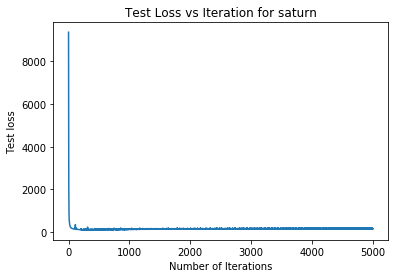

In [6]:
# max_itr = 5000
# for file in files:
#     for mode in ['train', 'test']:
#         plt.clf()
#         plt.plot(maps['{}_{}'.format(file, mode)])
#         plt.xlabel('Number of Iterations')
#         plt.ylabel('%s loss' % mode.capitalize())
#         plt.title('%s Loss vs Iteration for %s' % (mode.capitalize(), file))
#         plt.savefig('../data/output/denoise/{}_{}_{}'.format(file, mode, max_itr))

In [14]:
maps.keys()

dict_keys(['lena_train', 'lena_test', 'lena_model', 'lena_eta', 'saturn_train', 'saturn_test', 'saturn_model', 'saturn_eta'])

In [19]:
np.min(maps['lena_test'])

123.96431662193825

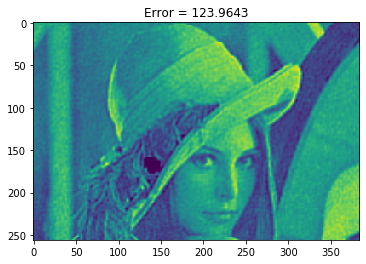

In [21]:
file = 'lena'
net = maps['%s_model' % file]
eta = maps['%s_eta' % file]
im = imread('../data/denoising/{}.png'.format(file))
out_img = net(eta)[0, 0, :, :].transpose(0,1).detach().numpy()
curr_error = ((im - out_img)**2).sum()
plt.title('Error = %.4f' % 123.96431662193825 )
plt.imshow(out_img)
plt.savefig('../data/output/denoise/{}_5000'.format(file))